In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#####https://www.analyticsvidhya.com/blog/2024/10/langgraph-react-function-calling/
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")
logging.info('junk')

DEBUG:root:test
INFO:root:junk


In [3]:
!pip install duckduckgo-search
!pip install langchain-community
!pip install langchain-experimental
!pip install langchain-openai
!pip install langchainhub
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from openai import OpenAI
#0. Setting the OpenAI API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY') #consumeskey via env variable
#1. GET your OpenAI API key from the OpenAI dashboard
#api_key = os.getenv("OPENAI_API_KEY")
#2. Create a new OpenAI instance
#client = OpenAI(api_key)
#3. Set the chat model
chat_model="gpt-4o-mini"

In [ ]:
import os
from langchain_openai import ChatOpenAI


#Initializing the language model
llm = ChatOpenAI(model=chat_model)

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b

In [7]:
# search tools
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

In [ ]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/JSV7aW5pdDogeydmbG93Y2hhcnQnOiB7J2N1cnZlJzogJ2xpbmVhcid9fX0lJQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXJlYXNvbmVyKHJlYXNvbmVyKQoJdG9vbHModG9vbHMpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiByZWFzb25lcjsKCXRvb2xzIC0tPiByZWFzb25lcjsKCXJlYXNvbmVyIC0uLT4gdG9vbHM7CglyZWFzb25lciAtLi0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 8961


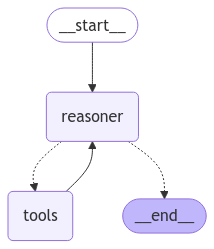

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})
#Displaying the response
for m in messages['messages']:
    m.pretty_print()

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.', 'role': 'system'}, {'content': "What is 2 times Brad Pitt's age?", 'role': 'user'}], 'model': 'gpt-4o-mini', 'stream': False, 'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.\nArgs:\n    a: firs

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_RREF33zO3JcfjpcHnpmuwZ07)
 Call ID: call_RREF33zO3JcfjpcHnpmuwZ07
  Args:
    query: Brad Pitt age 2023
================================= Tool Message =================================
Name: duckduckgo_search

Angelina Jolie and Brad Pitt, who split in 2016 and finalized their divorce in 2024, share six children. ... At age 15, he worked as an executive producer on Jolie's film First They Killed My ... Brad Pitt's latest birthday marks the third he is celebrating since starting to date girlfriend Inés de Ramón. The F1 actor celebrated his 61st birthday this December 18. Actor Brad Pitt is known the movies 'Fight Club,' 'The Curious Case of Benjamin Button,' and 'Moneyball.' Read about his age, girlfriend, children, and more. At the time of filming in early

In [8]:
##Adding a Custom Tool for Stock Prices
!pip -q install yahoo-finance

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 2.8 MB/s eta 0:00:00


In [9]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']
get_stock_price("AAPL")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
DEBUG:yfinance:get_raw_json(): https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAPL
DEBUG:yfinance:Entering get()
DEBUG:yfinance: Entering _make_request()
DEBUG:yfinance:url=https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAPL
DEBUG:yfinance:params={'modules': 'financialData,quoteType,defaultKeyStatistics,assetProfile,summaryDetail', 'corsDomain': 'finance.yahoo.com', 'formatted': 'false', 'symbol': 'AAPL'}
DEBUG:yfinance:  Entering _get_cookie_and_crumb()
DEBUG:yfinance:cookie_mode = 'basic'
DEBUG:yfinance:   Entering _get_cookie_and_crumb_basic()
DEBUG:peewee:('CREATE TABLE IF NOT EXISTS "_cookieschema" ("strategy" VARCHAR(255) NOT NULL PRIMARY KEY, "fetch_date" DATETIME NOT NULL, "cookie_bytes" BLOB NOT NULL) WITHOUT ROWID', [])
DEBUG:peewee:('SELECT "t1"."strategy", "t1"."fetch_date", "t1"."cookie_bytes" FROM "_cookieschema" AS "t1" WHERE ("t1"."strategy" = ?) LIMIT ? OFFSET ?', ['basic', 1, 0])
DEBUG:urllib3.c

235.74

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage
def reasoner1(state):
    query = state["query"]
    messages = state["messages"]
    # System message indicating the assistant's capabilities
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    # Invoke the LLM with the messages
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [ ]:
# Update the tools list to include the stock price function
tools = [add, multiply, divide, search, get_stock_price]
# Re-initialize the language model with the updated tools
llm = ChatOpenAI(model=chat_model)
llm_with_tools = llm.bind_tools(tools)


tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [13]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

In [14]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode
# Graph
workflow = StateGraph(GraphState)
# Add Nodes
workflow.add_node("reasoner", reasoner1)
workflow.add_node("tools", ToolNode(tools))

In [15]:
# Add Edges
workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

In [17]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

NameError: name 'Image' is not defined

In [19]:
response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?", "messages": []})
response['messages'][-1].pretty_print()

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.', 'role': 'system'}, {'content': "What is 2 times Brad Pitt's age?", 'role': 'user'}], 'model': 'gpt-4o', 'stream': False, 'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.\

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [20]:
response = react_graph.invoke({"query": "What is the stock price of Apple?", "messages": []})
for m in response['messages']:
    m.pretty_print()

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.', 'role': 'system'}, {'content': 'What is the stock price of Apple?', 'role': 'user'}], 'model': 'gpt-4o', 'stream': False, 'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})
for m in response['messages']:
    m.pretty_print()

In [ ]:
response = react_graph.invoke({"query": "What will be the price of nvidia stock if it doubles?", "messages": []})
for m in response['messages']:
    m.pretty_print()

In [ ]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})
for m in response['messages']:
    m.pretty_print()